In [1]:
import os, copy, torch, torch.nn as nn
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# ───────────────────────────── Config ────────────────────────────────
train_dir        = r'D:\Cellula Internship\Project_1_Teeth_Class\New_dataSet\Training'
val_dir          = r'D:\Cellula Internship\Project_1_Teeth_Class\New_dataSet\Validation'

num_classes      = 7
batch_size       = 32
img_size         = 224
epochs_phase1    = 5      # train classifier head only
epochs_phase2    = 15     # fine‑tune full network
lr_head          = 1e-3
lr_backbone      = 1e-4
weight_decay     = 1e-4
patience         = 5      # early‑stop if no val‑F1 improvement for N epochs
device           = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ───────────────────────── Augmentations ─────────────────────────────
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ───────────────────────────── Data ──────────────────────────────────
train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds   = ImageFolder(val_dir,   transform=val_tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ──────────────────────────── Model ──────────────────────────────────
weights = models.MobileNet_V2_Weights.DEFAULT          # ImageNet‑1k
model   = models.mobilenet_v2(weights=weights)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# ─────────────────────── Helper: run one epoch ───────────────────────
def run_epoch(dataloader, train_mode=True):
    model.train(train_mode)
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []

    for images, labels in tqdm(dataloader, leave=False):
        images, labels = images.to(device), labels.to(device)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(images)
            loss = criterion(outputs, labels)

            if train_mode:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total   += labels.size(0)
        correct += preds.eq(labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc  = 100 * correct / total
    epoch_f1   = f1_score(y_true, y_pred, average='macro')
    return epoch_loss, epoch_acc, epoch_f1

# ───────────────────────── Logging dict ──────────────────────────────
history = {
    'epoch':      [],
    'phase':      [],
    'train_loss': [],
    'train_acc':  [],
    'train_f1':   [],
    'val_loss':   [],
    'val_acc':    [],
    'val_f1':     [],
}

def log_epoch(epoch_label, phase_label,
              tr_loss, tr_acc, tr_f1,
              va_loss, va_acc, va_f1):
    history['epoch'].append(epoch_label)
    history['phase'].append(phase_label)
    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['train_f1'].append(tr_f1)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)
    history['val_f1'].append(va_f1)

# ───────────────────────────── Training ──────────────────────────────
best_f1, epochs_no_improve, best_state = 0.0, 0, None
global_epoch = 0

# ─── Phase 1: train head only ────────────────────────────────────────
for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.classifier.parameters(),
                             lr=lr_head, weight_decay=weight_decay)

for epoch in range(1, epochs_phase1 + 1):
    global_epoch += 1
    tr_loss, tr_acc, tr_f1 = run_epoch(train_dl, train_mode=True)
    va_loss, va_acc, va_f1 = run_epoch(val_dl,   train_mode=False)

    print(f"[Phase 1 | Epoch {epoch}/{epochs_phase1}] "
          f"Train F1: {tr_f1:.4f} | Val F1: {va_f1:.4f}")

    log_epoch(global_epoch, 'phase1',
              tr_loss, tr_acc, tr_f1,
              va_loss, va_acc, va_f1)

# ─── Phase 2: fine‑tune whole network ────────────────────────────────
for param in model.features.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr_backbone, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, epochs_phase2)

for epoch in range(1, epochs_phase2 + 1):
    global_epoch += 1
    tr_loss, tr_acc, tr_f1 = run_epoch(train_dl, train_mode=True)
    va_loss, va_acc, va_f1 = run_epoch(val_dl,   train_mode=False)
    scheduler.step()

    print(f"[Phase 2 | Epoch {epoch}/{epochs_phase2}] "
          f"Train F1: {tr_f1:.4f} | Val F1: {va_f1:.4f}")

    log_epoch(global_epoch, 'phase2',
              tr_loss, tr_acc, tr_f1,
              va_loss, va_acc, va_f1)

    # ── Early stopping on val‑F1 ────────────────────────────────────
    if va_f1 > best_f1:
        best_f1 = va_f1
        epochs_no_improve = 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# ─────────────────── Save best model checkpoint ─────────────────────
torch.save(best_state, "mobilenetv2_best_finetuned.pth")
print(f"Best validation macro‑F1: {best_f1:.4f}")

# ──────────────────────── Save training logs ────────────────────────
df = pd.DataFrame(history)
df.to_csv("training_log.csv", index=False)
print("Training log written to training_log.csv")

# ──────────────────────── Plot curves ────────────────────────────────
def plot_metric(metric, ylabel, filename):
    plt.figure(figsize=(8, 5))
    plt.plot(df['epoch'], df[f'train_{metric}'], label='Train', marker='o')
    plt.plot(df['epoch'], df[f'val_{metric}'],   label='Validation', marker='s')
    plt.xticks(df['epoch'])
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

plot_metric('f1',   'Macro‑F1 Score', 'f1_curve.png')
plot_metric('loss', 'Cross‑Entropy Loss', 'loss_curve.png')
plot_metric('acc',  'Accuracy (%)', 'accuracy_curve.png')

print("Plots saved: f1_curve.png, loss_curve.png, accuracy_curve.png")


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:03<00:00, 3.76MB/s]


[Phase 1 | Epoch 1/5] Train F1: 0.5222 | Val F1: 0.6646


[Phase 1 | Epoch 2/5] Train F1: 0.6371 | Val F1: 0.6722


[Phase 1 | Epoch 3/5] Train F1: 0.6644 | Val F1: 0.7203


[Phase 1 | Epoch 4/5] Train F1: 0.6768 | Val F1: 0.7370


[Phase 1 | Epoch 5/5] Train F1: 0.6834 | Val F1: 0.7320


[Phase 2 | Epoch 1/15] Train F1: 0.8330 | Val F1: 0.9563


[Phase 2 | Epoch 2/15] Train F1: 0.9506 | Val F1: 0.9877


[Phase 2 | Epoch 3/15] Train F1: 0.9751 | Val F1: 0.9928


[Phase 2 | Epoch 4/15] Train F1: 0.9865 | Val F1: 0.9941


[Phase 2 | Epoch 5/15] Train F1: 0.9900 | Val F1: 0.9941


[Phase 2 | Epoch 6/15] Train F1: 0.9942 | Val F1: 0.9958


[Phase 2 | Epoch 7/15] Train F1: 0.9951 | Val F1: 0.9941


[Phase 2 | Epoch 8/15] Train F1: 0.9949 | Val F1: 0.9949


[Phase 2 | Epoch 9/15] Train F1: 0.9964 | Val F1: 0.9970


[Phase 2 | Epoch 10/15] Train F1: 0.9971 | Val F1: 0.9973


[Phase 2 | Epoch 11/15] Train F1: 0.9980 | Val F1: 0.9981


[Phase 2 | Epoch 12/15] Train F1: 0.9989 | Val F1: 0.9981


[Phase 2 | Epoch 13/15] Train F1: 0.9976 | Val F1: 0.9992


[Phase 2 | Epoch 14/15] Train F1: 0.9979 | Val F1: 0.9992


[Phase 2 | Epoch 15/15] Train F1: 0.9984 | Val F1: 0.9983
Best validation macro‑F1: 0.9992
Training log written to training_log.csv
Plots saved: f1_curve.png, loss_curve.png, accuracy_curve.png


c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 33/33 [00:10<00:00,  3.25batch/s]


✅ Results saved to: D:\Cellula Internship\Project_1_Teeth_Class\logs\test_results_20250712_044035.txt


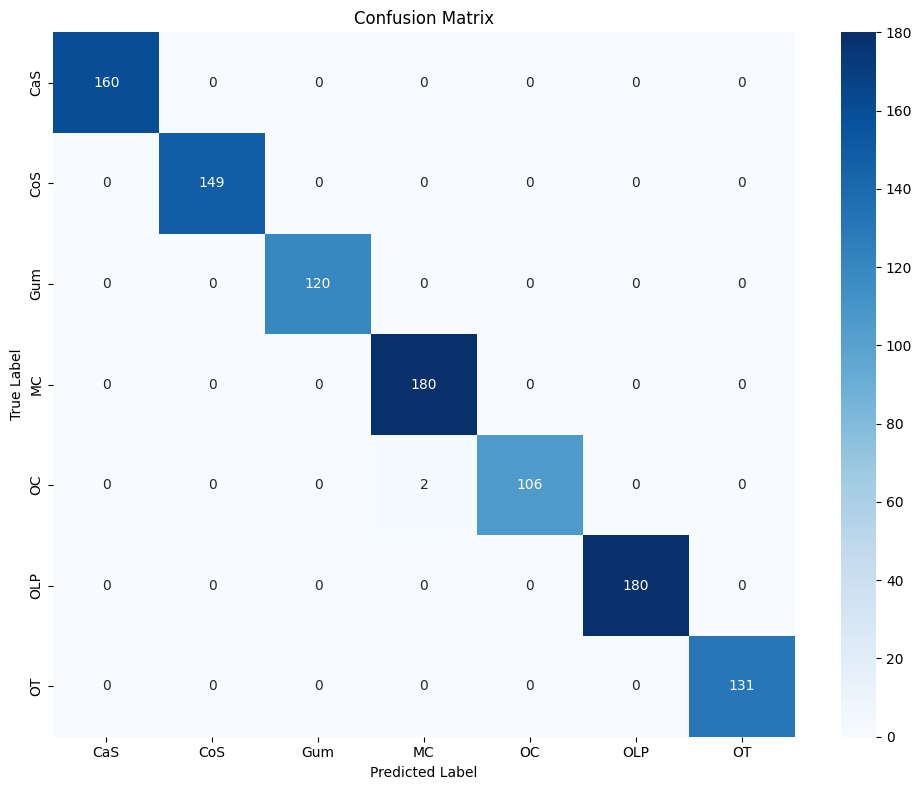

✅ Confusion‑matrix image saved to: D:\Cellula Internship\Project_1_Teeth_Class\logs\confusion_matrix_20250712_044035.png


In [2]:
"""
Full testing script for a MobileNet V2 finetuned model.
Saves:
  • Accuracy, macro‑F1, and full classification report to a timestamped log file
  • Confusion‑matrix heat‑map to a PNG image
"""

import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ───────────────────────────────── CONFIG ────────────────────────────────── #
test_dir   = r'D:\Cellula Internship\Project_1_Teeth_Class\Pre_augment\Teeth_Dataset\Testing'  # ▶ change if needed
model_path = r'D:\Cellula Internship\mobilenetv2_best_finetuned.pth'                         # ▶ change if needed
num_classes = 7
batch_size  = 32
img_size    = 224
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logging / output paths
log_root = r'D:\Cellula Internship\Project_1_Teeth_Class\logs'  # ▶ change if you prefer
os.makedirs(log_root, exist_ok=True)
run_stamp        = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file_path    = os.path.join(log_root, f"test_results_{run_stamp}.txt")
cm_image_path    = os.path.join(log_root, f"confusion_matrix_{run_stamp}.png")

# ───────────────────────────────── TRANSFORMS ────────────────────────────── #
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet mean
                         [0.229, 0.224, 0.225])   # ImageNet std
])

# ───────────────────────────────── DATASET / LOADER ──────────────────────── #
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader  = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2,
                          pin_memory=True)

# ───────────────────────────────── MODEL LOAD ────────────────────────────── #
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device).eval()

# ───────────────────────────────── TEST LOOP ─────────────────────────────── #
all_preds  = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ───────────────────────────────── METRICS ───────────────────────────────── #
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).mean() * 100
macro_f1 = f1_score(all_labels, all_preds, average='macro')
class_report = classification_report(all_labels,
                                     all_preds,
                                     target_names=test_dataset.classes,
                                     digits=4)
conf_mat = confusion_matrix(all_labels, all_preds)

# ───────────────────────────────── SAVE LOG FILE ─────────────────────────── #
with open(log_file_path, 'w', encoding='utf-8') as f:
    f.write("──────────────────────── TEST RESULTS ────────────────────────\n")
    f.write(f"Timestamp        : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Test directory   : {test_dir}\n")
    f.write(f"Model path       : {model_path}\n")
    f.write(f"Device           : {device}\n")
    f.write(f"Num classes      : {num_classes}\n")
    f.write("───────────────────────────────────────────────────────────────\n")
    f.write(f"Accuracy (%)     : {accuracy:.2f}\n")
    f.write(f"Macro‑F1         : {macro_f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(class_report)
    f.write("\n───────────────────────────────────────────────────────────────\n")
print(f"✅ Results saved to: {log_file_path}")

# ───────────────────────────────── CONFUSION MATRIX ──────────────────────── #
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(cm_image_path, dpi=300)
plt.show()
print(f"✅ Confusion‑matrix image saved to: {cm_image_path}")
